### Carregar Dados

- **Conjunto de Dados:** User Preference-aware Fake News Detection (UPFD)
- O conjunto de dados contém postagens e metadados sobre como as notícias se espalham no Twitter, incluindo interações de usuários e grafos de propagação.
- Cada amostra é um grafo representando a disseminação de uma notícia, com nós como usuários e arestas como relações de retweet ou compartilhamento.
- O objetivo é classificar cada notícia como real ou falsa com base no padrão de propagação e nas características do conteúdo.

In [3]:
from torch_geometric.datasets import UPFD

test = UPFD(root=".", name="gossipcop", feature="content", split="train")
train = UPFD(root=".", name="gossipcop", feature="content", split="test")
print(f"Test: {len(test)}")
print(f"Train: {len(train)}")

  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)


Extracting ./gossipcop/raw/data.zip
Processing...
Done!


Test: 1092
Train: 3826


In [4]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train, batch_size=128, shuffle=True)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [5]:
train._data

Data(x=[219989, 310], edge_index=[2, 216163], y=[3826])

In [6]:
i = 0
train[i]

Data(x=[116, 310], edge_index=[2, 115], y=[1])

In [7]:
train[i].node_stores

[{'x': tensor([[0.4762, 0.4986, 0.5922,  ..., 0.4608, 0.1049, 0.1725],
         [0.4536, 0.5054, 0.6587,  ..., 0.3151, 0.1111, 0.1618],
         [0.4762, 0.4986, 0.5922,  ..., 0.4608, 0.1049, 0.1725],
         ...,
         [0.5111, 0.5022, 0.4710,  ..., 0.2534, 0.0556, 0.4118],
         [0.3148, 0.4548, 0.5879,  ..., 0.5548, 0.1111, 0.2500],
         [0.5202, 0.4781, 0.4777,  ..., 0.8699, 0.0556, 0.2647]]), 'edge_index': tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
            1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
            1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
            1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
            1,   7,  15,  15,  15,  15,  15,  41,  42,  42,  42,  42,  42,  42,
           42, 

### Visualização do Grafo

Visualize a estrutura de um grafo de propagação de notícias. Cada nó representa um usuário e cada aresta representa um retweet ou compartilhamento. Isso ajuda a entender como a informação se espalha e como notícias reais e falsas podem se propagar de maneiras diferentes.

In [8]:
import networkx as nx

def draw_graph(data):
  G = nx.Graph()
  for _, (u, v) in enumerate(data.edge_index.t().tolist()):
    G.add_edge(u, v)
  pos = nx.spring_layout(G, k=2)
  nx.draw(G,pos,with_labels=True)

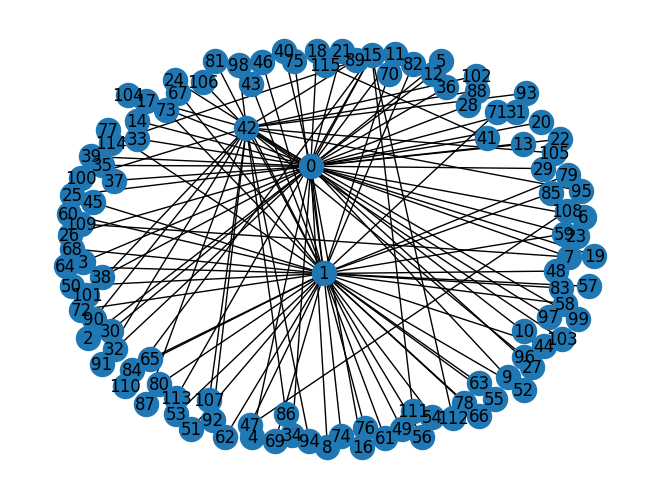

In [9]:
# 0: twitch originario
# 1-n: replicação do twitch
draw_graph(train[i])

In [10]:
real = [data.y.item() for data in train if data.y.item()==0]
fake = [data.y.item() for data in train if data.y.item()==1]
print(f"Real news: {len(real)}")
print(f"Fake news: {len(fake)}")

Real news: 1910
Fake news: 1916


## Modelo de Rede Neural em Grafos (GNN)

Nesta seção, definimos e treinamos uma Rede Neural em Grafos para classificar notícias como reais ou falsas. O modelo utiliza tanto as características do conteúdo quanto a estrutura do grafo de propagação para fazer as previsões.

In [11]:
from dataclasses import astuple
from torch_geometric.nn import global_max_pool, GCN
from torch.nn import Linear, Module
import torch
from sklearn.metrics import accuracy_score, f1_score


class GNN(Module):
  def __init__(self, in_channels, hidden_channels, out_channels, num_layers) -> None:
    super().__init__()

    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.to(self.device)

    self.fst_conv = GCN(in_channels, hidden_channels, num_layers)
    self.snd_conv = GCN(hidden_channels, hidden_channels, num_layers)
    self.trd_conv = GCN(hidden_channels, hidden_channels, num_layers)

    self.lin_news = Linear(in_channels, hidden_channels)
    self.lin0 = Linear(hidden_channels, hidden_channels)
    self.lin1 = Linear(2*hidden_channels, out_channels)


  def forward(self, x, edge_index, batch):
    h = self.fst_conv(x, edge_index).relu()
    h = self.snd_conv(h, edge_index).relu()
    h = self.trd_conv(h, edge_index).relu()

    h = global_max_pool(h, batch)
    h = self.lin0(h).relu()

    root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
    root = torch.cat([root.new_zeros(1), root + 1], dim=0)

    news = x[root]
    news = self.lin_news(news).relu()

    out = self.lin1(torch.cat([h, news], dim=-1))

    return torch.sigmoid(out)




In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train.num_features, 128, 1, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01, weight_decay=0.01)
loss_fn = torch.nn.BCELoss()


def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fn(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fn(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())

    accuracy, f1 = metrics(all_preds, all_labels)
    return total_loss / len(test_loader.dataset), accuracy, f1

def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)

    accuracy = accuracy_score(gts, preds)
    f1 = f1_score(gts, preds)
    return accuracy, f1

In [14]:
for epoch in range(25):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)

    print(f"Epoch: {epoch:02d} | TrainLoss: {train_loss:.2f} | TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}")

Epoch: 00 | TrainLoss: 0.50 | TestLoss: 0.56 | TestAcc: 0.60 | TestF1: 0.71
Epoch: 01 | TrainLoss: 0.48 | TestLoss: 0.42 | TestAcc: 0.89 | TestF1: 0.87
Epoch: 02 | TrainLoss: 0.44 | TestLoss: 0.42 | TestAcc: 0.85 | TestF1: 0.87
Epoch: 03 | TrainLoss: 0.40 | TestLoss: 0.36 | TestAcc: 0.92 | TestF1: 0.92
Epoch: 04 | TrainLoss: 0.36 | TestLoss: 0.38 | TestAcc: 0.84 | TestF1: 0.81
Epoch: 05 | TrainLoss: 0.36 | TestLoss: 0.32 | TestAcc: 0.93 | TestF1: 0.93
Epoch: 06 | TrainLoss: 0.34 | TestLoss: 0.30 | TestAcc: 0.93 | TestF1: 0.93
Epoch: 07 | TrainLoss: 0.31 | TestLoss: 0.29 | TestAcc: 0.93 | TestF1: 0.93
Epoch: 08 | TrainLoss: 0.31 | TestLoss: 0.37 | TestAcc: 0.81 | TestF1: 0.76
Epoch: 09 | TrainLoss: 0.31 | TestLoss: 0.29 | TestAcc: 0.92 | TestF1: 0.93
Epoch: 10 | TrainLoss: 0.30 | TestLoss: 0.26 | TestAcc: 0.94 | TestF1: 0.94
Epoch: 11 | TrainLoss: 0.28 | TestLoss: 0.26 | TestAcc: 0.94 | TestF1: 0.94
Epoch: 12 | TrainLoss: 0.27 | TestLoss: 0.25 | TestAcc: 0.94 | TestF1: 0.94
Epoch: 13 | 

## Predição e Resultados

Utilize o modelo GNN treinado para prever se as notícias no conjunto de teste são reais ou falsas. Os resultados são exibidos em um DataFrame, mostrando a probabilidade prevista, a predição binária e o rótulo verdadeiro de cada amostra.

In [16]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

all_preds = []
all_trues = []
all_probs = []

for data in test_loader:
    data = data.to(device)
    pred = model(data.x, data.edge_index, data.batch)
    all_probs.extend(pred.detach().cpu().numpy()[:, 0])
    all_preds.extend(torch.round(pred).detach().cpu().numpy()[:, 0])
    all_trues.extend(data.y.cpu().numpy())

df = pd.DataFrame({
    "pred_final": all_probs,
    "pred": all_preds,
    "true": all_trues
})

acc = accuracy_score(df["true"], df["pred"])
f1 = f1_score(df["true"], df["pred"])

print(f"Acurácia: {acc:.4f}")
print(f"F1-score: {f1:.4f}")

display(df)

Acurácia: 0.9011
F1-score: 0.9071


,pred_final,pred,true
0,0.208688,0.0,0
1,0.877091,1.0,1
2,0.993352,1.0,1
3,0.115655,0.0,0
4,0.176820,0.0,0
...,...,...,...
1087,0.732314,1.0,0
1088,0.890541,1.0,1
1089,0.949444,1.0,1
1090,0.177277,0.0,0
